# ast 266 Imran Hasan HW 4

In [1]:
#import some useful things
from astropy.table import Table
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/Users/ih64/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Problem 1: Linear Fitting

Lets repackage our data. If we have N data points, we can group the wavelength data, our model for each data point, and the model parameters in their own matricies as well as S, a covariance matrix for the errors. The errors are assumed to be independent so S will be diagonal

$$ \mathbf{Y}=\begin{bmatrix}
y_{0}\\
y_{1}\\
y_{2}\\
.\\
y_{N-1}
\end{bmatrix}
,\
\mathbf{a}=\begin{bmatrix}
\alpha_{0}\\
\alpha_{1}\\
\end{bmatrix}
\mathbf{X}=\begin{bmatrix}
1 && x_{0}\\
1 && x_{1}\\
1 && x_{2}\\
. && .\\
1 && x_{N-1}\\
\end{bmatrix}
,\
\mathbf{S}=\begin{bmatrix}
\sigma_{0}^{2} && 0 && . && 0\\
0 && \sigma_{1}^2 && . && 0\\
. && . && . && .\\
0 && 0 && . && \sigma_{N-1}^{2}
\end{bmatrix}$$

Now we can neatly rewrite the solution for the linear weights using the formalism developed in class

$$a = (X^{T}S^{-1}X)^{-1}(X^{T}S^{-1}Y)$$

notice the right most term, $X^{T}S^{-1}Y$, is what we have called $\beta$ and the left most term, $X^{T}S^{-1}X$, is what we have called $\alpha$

### a) Find the best fit parameters

In [2]:
#read in the data
wave_data=Table.read('wavecal.txt', format='ascii')

#unpackage the data. We are aiming to have vectors and matricies described above
y=wave_data['x_postion'].data
xi=wave_data['wavelength'].data

#create a square matrix of errors. we will assume .4 pixels as the error for each
#the diagonal elements are all 1/.16, which represents the squared uncertainty in pixels
s_inv=np.identity(len(wave_data))*(1/.16)

#create the matrix X, which represents the functions used for the model.
#we are using a straight line as our model so we will take the wavelength data 
#and pad them with a column of ones
X=np.hstack((np.vstack(np.ones(len(xi))),np.vstack(xi)))

In [3]:
def linearFit(X,y,s_inv):
    '''
    a function to do linear regression
    input:
    X: a matrix with n rows and m columns, where n is the number of of data points
        and m is the number of functions in the linear model. the ith column
        represents the ith function in the model
    y: a column vector of length n, containing the 'true' values we are trying to fit
    s_inv: an n by n matrix containing the covariance errors. each element is the inverse of the ijth error in y
    
    output:
    a: the linear weights for each function in the model
    '''
    #define beta
    beta=X.T.dot(s_inv.dot(y))

    #now to define alpha. use some nested matrix multiplication
    alpha=X.T.dot((s_inv.dot(X)))

    #take the inverse of alpha
    alpha_inv=np.linalg.pinv(alpha)
    #finally solve for the parameters
    a=alpha_inv.dot(beta)
    print "the model parameters are "
    print a
    return a

In [4]:
#call our function to do linear fitting on the data
#the values that are printed are a0 and a1, respectively
a_linear=linearFit(X,y,s_inv)

the model parameters are 
[ -1.90473299e+03   6.10302583e-01]


### b) calculate $\chi^2$ and reduced $\chi^2$

In [44]:
#all the errors are the same, so this will simplify the calculation.
#lets find the residuals, square them, divide each by the error, and compute the sum
#then to get the reduced one normalize by n-2 since we have 2 parameters in our model

#we can use our best fit parameters to create model predictions
y_model=np.dot(X,a_linear)

def chisq(y,y_model,variance,dof):
    chi_sq_array=np.square(y - y_model)/variance
    chi_sq = chi_sq_array.sum()
    chi_sq_red=chi_sq/dof
    
    return [chi_sq, chi_sq_red]
    
chi_sq_lin, chi_sq_red_lin = chisq(y,y_model,.16,len(y)-2)
print "the chi squared and reduced chi squared are %.3f and %.3f respectively " %(chi_sq_lin, chi_sq_red_lin)

the chi squared and reduced chi squared are 10342.945 and 369.391 respectively 


In [40]:
#we can calculate the variance matrix by taking the inverse of the matrix alpha
#lets borrow a snippet from the above function
alpha=X.T.dot((s_inv.dot(X)))
print np.linalg.pinv(alpha)

[[  1.28170050e-01  -2.42001505e-05]
 [ -2.42001505e-05   4.76768915e-09]]


### c) plot the residuals

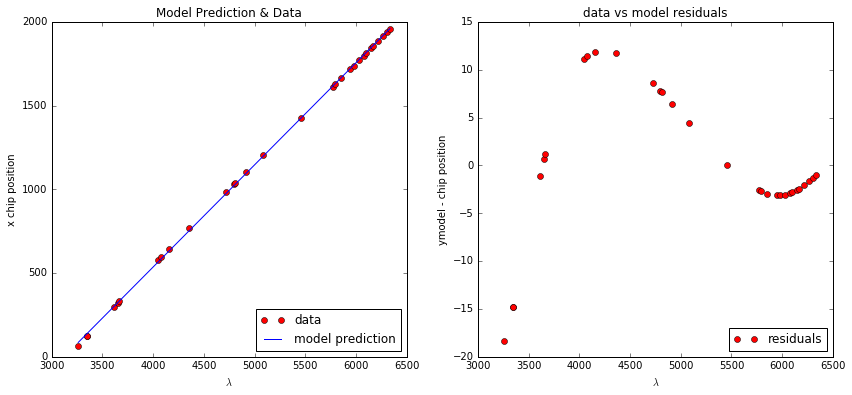

In [5]:
#lets make a function that creates a plot of the model and residuals
def plt_model_residuals(xi, y, y_model):
    figure=plt.figure(figsize=(14,6))
    ax1=figure.add_subplot(121)
    ax1.plot(xi, y, 'ro', label="data")
    ax1.plot(xi, y_model, label='model prediction')
    ax1.legend(loc='lower right')
    ax1.set_title('Model Prediction & Data')
    ax1.set_xlabel('$\lambda$')
    ax1.set_ylabel('x chip position')

    ax2=figure.add_subplot(122)
    ax2.plot(xi, y - y_model,'ro', label="residuals")
    ax2.legend(loc='lower right')
    ax2.set_title('data vs model residuals')
    ax2.set_xlabel('$\lambda$')
    ax2.set_ylabel('ymodel - chip position')
    return

plt_model_residuals(xi,y,y_model)

The model may nievely appear to be accurate if we just plot it with the raw data, but the residuals reveal some troubling structure. overall, this is not a good model

### d) make a quadratic model

In [6]:
#we can quickly make a polynomial model now using our function from last time. we just have to redefine 
#the matrix X to include a column of lambda squared values.
#the remaining definitions of the error matrix and chip values are unchanged
xi_sq=np.square(xi)

In [7]:
X2=np.hstack((np.vstack(np.ones(len(xi))),np.vstack(xi),np.vstack(xi_sq)))

#the parameters are a0, a1, and a2 respectively
a_quadratic=linearFit(X2,y,s_inv)

the model parameters are 
[ -8.38096942e-05  -1.97367503e-01   8.17336744e-05]


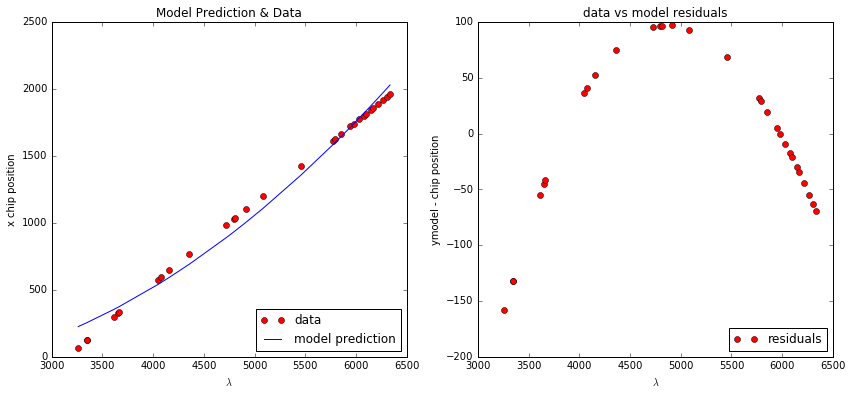

In [9]:
y_quad_model=X2.dot(a_quadratic.reshape(3,1)).flatten()
plt_model_residuals(xi,y,qmodel)

This looks like an even worse fit(!) This is not what we expect at all. If anything the coefficent for the lambda squared term could be set to zero and we should recover the linear fit, which had residuals that were almost an order of magnitude less.

After messing around for a few hours, I tried some sanity tests on my algorithm to see if I can recover an odvious answer

In [21]:
qmodel=a_quadratic[0] + a_quadratic[1]*xi + a_quadratic[2]*np.square(xi)

xx=np.hstack((np.vstack(np.ones(30)),np.vstack(np.linspace(0,10,30)),np.vstack(np.square(np.linspace(0,10,30)))))
yy=np.ones(30) + 6*np.linspace(0,10,30) + 9*np.square(np.linspace(0,10,30))
linearFit(xx,yy,np.identity(30))

the model parameters are 
[ 1.  6.  9.]


array([ 1.,  6.,  9.])

We get back the exact right answer. One systematic difference between the test case and the data are the range of the indepenent variables. the wavelengths are about 4 orders of magnitude and when they are squared they blow up to 9 orders. after playing around for a few hours I decided to rescale the wavelengths by multiplying each by .001 to see if this could help

In [35]:
#do the same procedue as above but with wavelengths in different units
xii=xi*.001
xii_sq=np.square(xii)
X22=np.hstack((np.vstack(np.ones(len(xii))),np.vstack(xii),np.vstack(xii_sq)))
a2_fit=linearFit(X22,y,s_inv)

the model parameters are 
[-2078.90787841   685.415206      -7.70324311]


we have to remember to scale this back up to our former units. so the first coefficent remains unchanged, the second one becomes 685.415206 x .001 = .6853 and the third becomes -7.7032 x (.001)^2 = -0.0000077032. qualitatively speaking for a moment, this model appears more encouraging. the values for a0 and a1-after being scaled back to the right units-are in the neighborhood of the previous model, and the next parameter looks like it can be thought of as the next-to-highest-order correction. lets keep this answer and ditch the funny one.

### e) plot the new residuals

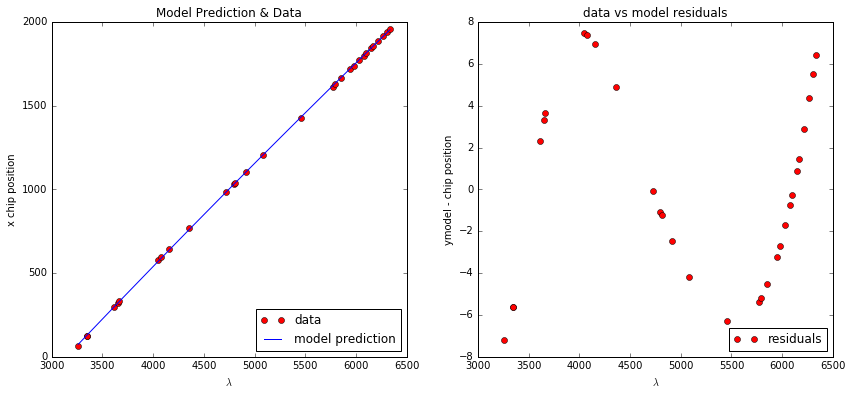

In [42]:
a2_model=X22.dot(a2_fit)
plt_model_residuals(xi,y,a2_model)

now the fit does not look as pathologically horrible, and the residuals have actually decreased. However, they still have considerale structure-almost sinusodial even-so after all that trouble this is still not a good fit. Let us quantify this by finding $\chi^2$ and $\chi^2_\nu$

In [45]:
chi_sq_poly, chi_sq_red_poly = chisq(y,a2_model,.16,len(y)-3)
print "the chi squared and reduced chi squared are %.3f and %.3f respectively " %(chi_sq_poly, chi_sq_red_poly)

the chi squared and reduced chi squared are 3708.075 and 137.336 respectively 


## Problem 2: Sigma Clipping

In [10]:
#read in our data file
hdulist=fits.open('0631_gmos_q2006_i.fits')
imdata=hdulist[0].data

#make a copy of the data and flatten it
temp_imdata=imdata.copy().flatten()

#calculate the mean and std of the data
print "the mean and std of the data is %.3f and %.3f counts respectively" %(temp_imdata.mean(), temp_imdata.std())

the mean and std of the data is 11952.414 and 9534.626 counts respectively


In [11]:
def sigmaClip(data, nsigma, call=1):
    '''sigma clipping algorithm. recieves a numpy array, identifies mean, std, discards elements
    above or below nsigma*std the mean, repeat until no more elements are outside threshold.
    
    python is notoriously slow with loops. instead we implement a recursive algorithm.
    if elements have been discarded, the function will call itself and continue to do so
    until there are no more elements outside of threshold
    
    inputs:
        data: a 1d numpy array
        nsigma: the number of sigma away from the mean you want to clip off
        call: counts the number of recursive call the function makes. 
    outputs: 
        data: the surviving elements from input data
    '''
    
    #calculate the mean, std, and threshold
    mean=data.mean()
    std=data.std()
    threshold=nsigma*std
    
    #define the upper limit
    up_thresh=mean+threshold
    #define lower limit
    down_thresh=mean-threshold
    
    #create the mask to identify elements between thresholds
    good_mask= ((data <= up_thresh) & (data >= down_thresh))

    #define the testcase. if this is true the program will exit
    #if there are no elements above or below threshold, we're done.
    #print out the mean and std, then return the clipped array.
    #finally, return the masked array 
    if data[~good_mask].size == 0:
        print "after %i recursive calls, we have no more elements outside threshold" %(call)
        print "the mean and std of the final clipped array are %.5f and %.5f respectively" %(data.mean(), data.std())
        return data
    
    #if that's not the case, recurse on the subproblem. 
    #keep using the same nsigma the user defined in the very first call
    #incrament the call by one so we can keep track of how many recursive calls the function makes
    #then the function will call itself on the clipped version of the data array it recieved
    else:
        call+=1
        return sigmaClip(data[good_mask], nsigma,call=call)

In [12]:
a=sigmaClip(temp_imdata, 3)

after 31 recursive calls, we have no more elements outside threshold
the mean and std of the final clipped array are 11158.75391 and 130.24193 respectively


In [13]:
a.size

4734801

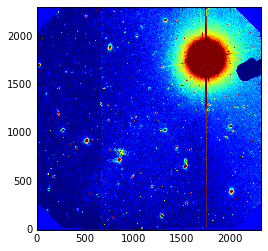

In [46]:
#now we display the image using the mean and std we found
plt.imshow(imdata, vmin=(11158.75391-130.24193), vmax=(11158.75391 + 10*130.24193), origin='lower')

## Problem 3: Flat Field Files

In [15]:
#first lets use glob to grab all the flat files
import glob
flat_names=glob.glob('Flat*V*.fits')

#I tried making a parent numpy array that will hold the data values of the fits images
#but it complained about the shapes and sizes. I could have first declared a seperate 
#array with matching dimensions, starting off w all zeros
#something like np.zeroes((5,510,765)), then assignign the data values
#but I was worried about running out of memeory w 2 of those big old arrays

#we will have to loop over the 5 images to dump their data out. we will initialize it
#as a list, then convert it to an numpy array when we want to do operations on it
#looping over 5 things is bearable

parent_flat=[]

for i in xrange(0,len(flat_names)):
    hdulist=fits.open(flat_names[i])
    parent_flat.append(hdulist[0].data)
    hdulist.close()


#convert this to a numpy array
parent_flatAr=np.array(parent_flat)
#now we can quickly calculate the medians
medians=np.median(parent_flatAr, axis=(1,2))

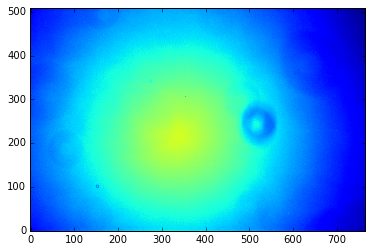

In [47]:
#normalize each flat by its median
#i had to do the same work around with a list then converting it to an array
#when i try to do this array wise it all the pixel values become zero. maybe a memory problem?
#ive found numpy to be finicky at times on my computer with this type of suff. 
#maybe i have to make a precision setting somewhere 

#we commit the sin of doing a python loop
normalized_flats=[]
for i in xrange(0,5):
    normalized_flats.append(parent_flatAr[i]/medians[i])
    
#make it an array and quickly calculate the mean flat
avg_flat=np.array(normalized_flats).mean(axis=0)

plt.imshow(avg_flat, origin='lower')